In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import h5py
import os
import sys

%matplotlib inline

/Users/zytec/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 读取数据

In [2]:
total_df = pd.read_csv('./data/train.csv')
total_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
final_df = pd.read_csv('./data/test.csv')
final_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
total_X = total_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
total_Y = total_df.iloc[:, 0].values.reshape(-1, 1)
final_X = final_df.iloc[:, :].values.reshape(-1, 28, 28, 1)

print('total_X:', total_X.shape)
print('total_Y:', total_Y.shape)
print('final_X:', final_X.shape)

total_X: (42000, 28, 28, 1)
total_Y: (42000, 1)
final_X: (28000, 28, 28, 1)


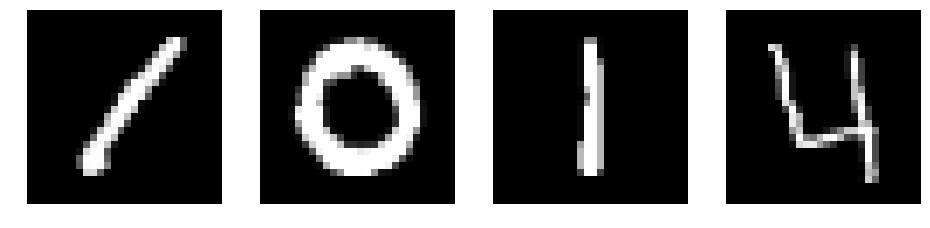

In [5]:
plt.figure(figsize=(16, 16))
plt.rcParams['image.cmap'] = 'gray'
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(total_X[i, :, :, 0])
    plt.axis('off')

### 数据随机化

In [6]:
random_indexes = np.random.permutation(total_X.shape[0])
total_shuffle_X = total_X[random_indexes]
total_shuffle_Y = total_Y[random_indexes]

### 用imagenet预训练的resnet提取所有图片特征，保存到文件

In [7]:
class Features_saver:
    def __init__(self, file_path, total_size, feature_size):
        if os.path.exists(file_path):
            os.remove(file_path)
        
        self._h5f = h5py.File(file_path, mode='a')
        self._dataset = self._h5f.create_dataset("features", (total_size, feature_size),
                                                 maxshape=(None, feature_size),
                                                 dtype='float32')
        self._last_point = 0
        
    def __del__(self):
        if self._h5f != None:
            self._h5f.close()
            self._h5f = None
            
    def save_features(self, features):
        self._dataset[self._last_point: self._last_point + features.shape[0]] = features
        self._last_point += features.shape[0]
        
    def save_labels(self, labels):
        self._h5f['labels'] = labels
        
    def close(self):
        if self._h5f != None:
            self._h5f.close()
            self._h5f = None

In [8]:
def build_placeholder():
    inputs = tf.placeholder(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    
    return inputs

In [9]:
def image_process_map(image):
    rgb_image = tf.concat([image, image, image], axis=-1)
    resize_image = tf.image.resize_images(rgb_image, size=(224, 224))
    pre_image = keras.applications.resnet50.preprocess_input(resize_image, mode='tf')
    
    return pre_image;

In [10]:
def data_gen(images, batch_size):
    images_set = tf.data.Dataset.from_tensor_slices(images)
    images_set = images_set.batch(batch_size)
    images_set = images_set.repeat(1)
    images_set = images_set.map(image_process_map, 8)
    images_gen = images_set.make_one_shot_iterator()
    next_images = images_gen.get_next()
    
    return next_images

In [11]:
def features_extract(file_path, images, labels=None, batch_size=8):  
    tf.reset_default_graph()
    
    inputs_pl = build_placeholder()
    resnet = keras.applications.resnet50.ResNet50(include_top=False, input_tensor=inputs_pl, pooling='avg')
    
    with tf.device('/cpu:0'):
        images_gen = data_gen(images, batch_size)
        
    feature_saver = Features_saver(file_path, images.shape[0], 2048)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    step = 0
    while True:
        try:
            input_images = sess.run(images_gen)
            batch_features = sess.run(resnet.output, feed_dict={inputs_pl: input_images})
            
            feature_saver.save_features(batch_features)
            
            sys.stdout.write('\r%{:.2f}    '.format(100 * step * batch_size / images.shape[0]))
            sys.stdout.flush()
            step += 1
        except tf.errors.OutOfRangeError:
            sys.stdout.write('\r%100    ')
            sys.stdout.flush()
            print('')
            print('Feature extraction complete')
            break
    
    if isinstance(labels, np.ndarray):
        feature_saver.save_labels(labels)
        
    feature_saver.close()
    sess.close()

In [12]:
features_extract('total_features.h5', total_shuffle_X[:20], total_shuffle_Y[:20])

%100      
Feature extraction complete


In [13]:
# features_extract('final_test_features.h5', final_X[:10])